In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, accuracy_score, make_scorer, roc_auc_score
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, 
                                   RobustScaler, FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from geopy.distance import geodesic
import datetime

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 0bf8bc6e-30d0-4c50-956a-603fc693d966.csv to 0bf8bc6e-30d0-4c50-956a-603fc693d966.csv
Saving 702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv to 702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv
Saving 4910797b-ee55-40a7-8668-10efd5c1b960.csv to 4910797b-ee55-40a7-8668-10efd5c1b960.csv
Saving csvData.csv to csvData.csv
Saving tz.csv to tz.csv


In [ ]:
# IMPORT DATASETS
y = pd.read_csv('0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
X = pd.read_csv('4910797b-ee55-40a7-8668-10efd5c1b960.csv')
final_test = pd.read_csv('702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')

In [ ]:
X.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [ ]:
y.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [ ]:
y.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [ ]:
# check if 'id' column in both X_train and y_train line up correctly
(X.id.values == y.id.values).all()

True

In [ ]:
# CHECK FOR NaN VALUES IN X
X.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [ ]:
for col in X.columns:
    if X[col].nunique() <= 1:
        print(col)

recorded_by


In [ ]:
# We can remove 'recorded_by' column due to lack of variance
drop_cols = ['recorded_by']

### Concat `X` and `y` into 1 dataframe

In [ ]:
df = pd.concat([X, y], axis=1)

In [ ]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,id,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,69572,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,8776,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,34310,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,67743,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,19728,functional


In [ ]:
# Add 'id' columns to the drop list
drop_cols.append('id')

In [ ]:
# Drop column `scheme_name` due to high amount of missing values
drop_cols.append('scheme_name')

In [ ]:
drop_cols

['recorded_by', 'id', 'scheme_name']

In [ ]:
# drop 
df = df.drop(drop_cols, axis=1)

In [ ]:
df.duplicated().sum()

36

In [ ]:
# Drop duplicated entries
df.drop_duplicates(keep='first', inplace=True)

There're 1001 entries with a value of 0 for longitude. Technically, longitude range for Tanzania should not be below 29. 

For these placeholder-0 values, I will consider:
1. Dropping them
2. Imputing them with the average of valid longitudes grouped by region_code (this is a little challenging for me right now, since ideally I'd like to incorporate it into a Pipeline)

In [ ]:
df.isna().sum()

amount_tsh                  0
date_recorded               0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                371
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3314
scheme_management        3877
permit                   3056
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source                      0
source_typ

#### Dropping rows with placeholder-0 longitude

In [ ]:
# df2 = df[df.longitude >= 29].copy()

In [ ]:
# df2.isna().sum()

In [ ]:
# df2.info()

### Train Test Split

In [ ]:
df.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group'],
      dtype='object')

In [ ]:
X_master = df.drop('status_group', axis=1)
y_master = df.status_group

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_master, y_master, random_state=2021)

In [ ]:
print(f'Training: {X_train.shape} | {y_train.shape}')
print(f'Testing: {X_test.shape} | {y_test.shape}')

Training: (44523, 37) | (44523,)
Testing: (14841, 37) | (14841,)


In [ ]:
# Split training dataset further into training (for modeling fitting & tuning) 
# and validation (for model validating throughout the process)
X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, random_state=2021)

In [ ]:
# def convert_to_datetime(x):
#     # df['date_recorded'] = pd.to_datetime(df['date_recorded'], errors='raise')
#     # return df
#     datetime_obj = datetime.datetime.strptime(x, '%Y-%m-%d')
#     return datetime_obj

# date_transformer = Pipeline(steps=[    
#     ('convert_to_datetime', FunctionTransformer(np.vectorize(convert_to_datetime), validate=False))
# ])

In [ ]:
convert_to_datetime('2013-09-03')

datetime.datetime(2013, 9, 3, 0, 0)

In [ ]:
to_datetime = ['date_recorded']

In [ ]:
# # Extract year_/month_/age_recorded
# X_train['month_recorded'] = X_train.date_recorded.dt.month_name().str.slice(stop=3)
# X_train['year_recorded'] = X_train.date_recorded.dt.year
# X_train['age_recorded'] = X_train.year_recorded - X_train.construction_year

In [ ]:
X_tt.isna().sum()

From EDA, it appears that `Unknown` or `Other` values does provide some information. Therefore, I will proceed to fill in `NaN` values in some of these columns with the string `"NaN"`:

In [ ]:
boolean_cols = ['public_meeting', 'permit']

def convert_to_str(x):
    return str(x)

to_str_transformer = Pipeline(steps=[
    ('to_str', FunctionTransformer(np.vectorize(convert_to_str), validate=False))
])

In [ ]:
to_fillna = ['public_meeting', 'scheme_management', 'permit']

fillna_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value="NaN")),
    ('to_str', FunctionTransformer(np.vectorize(convert_to_str), validate=False))
])

In [ ]:
preprocessor_1 = ColumnTransformer(transformers=[('date', date_transformer, to_datetime),
                                                 ('fillna', fillna_transformer, to_fillna)],
                                   remainder='passthrough')

In [ ]:
# X_test.shape

In [ ]:
# X_test_ft = preprocessor_1.fit_transform(X_test)

In [ ]:
# X_test_df = pd.DataFrame(X_test_ft)

In [ ]:
# X_test_df.head()

In [ ]:
# X_test[to_fillna] = fillna_transformer.fit_transform(X_test[to_fillna])
# X_test[boolean_cols] = to_str_transformer.fit_transform(X_test[boolean_cols])

In [ ]:
# X_test[to_fillna].permit.value_counts().index[0]

In [ ]:
class NaNImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        to_fillna = ['public_meeting', 'scheme_management', 'permit']
        X[to_fillna] = X[to_fillna].fillna(value='NaN')
        X[to_fillna] = X[to_fillna].astype(str)
           
        return X

In [ ]:
pipe = Pipeline(steps=[('fillna', NaNImputer())])
test_3 = pipe.fit_transform(test)

In [ ]:
# test_3.scheme_management.value_counts()

### Replacing 0 in longitude with average longitude grouped by `region_code`

In [ ]:
# Custom Transformer that replaces invalid longitude = 0 with the means of longitude group by region_code
class LongitudeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.lng_means_ = {}

    def fit(self, X, y=None):
        self.lng_means_ = X.groupby(['region_code']).longitude.mean()

        return self

    def transform(self, X, y=None):
        # replace 0 with average longitude
        for key, value in self.lng_means_.items():
            X.loc[((X.longitude == 0) & (X.region_code == key)), 'longitude'] = value

        return X

In [ ]:
lng_imputer = Pipeline(steps=[
    ('lng_imp', LongitudeImputer())
])

In [ ]:
# X_test2 = lng_transformer.fit_transform(X_test)

In [ ]:
# X_test2.longitude.describe()

In [ ]:
# # Putting them all together
# preprocessor_1 = ColumnTransformer(transformers=[('fillna', fillna_transformer, to_fillna)],
#                                    remainder='passthrough')

In [ ]:
# X_test3 = pp_1_2.fit_transform(X_test2)

In [ ]:
# X_test3.shape

In [ ]:
# pipe = Pipeline(steps=[('lng', LongitudeImputer()),
#                        ('preprocess', preprocessor_1)])

In [ ]:
X_test2 = pipe.fit_transform(X_test)

In [ ]:
# X_test2_df = pd.DataFrame(X_test2)
# X_test2_df.head()

In [ ]:
# (X_test2_df[8] == 0).any()

### Funder & Installer

Currently `funder` and `installer` have high amount of unique values (both with more than 1000). This would most create an unnecessary amount of extra features once the dataset gets One Hot Encoded, especially when some of these entities are only responsible for 1-2 wells. Therefore, I am going to bin each of these 2 features into 2 smaller groups (major and minor).

In [ ]:
class FunderBinner(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.top_100_funder = []

    def fit(self, X, y=None):
        self.top_100_funder = X.funder.value_counts()[:100].index

        return self

    def transform(self, X, y=None):
        for idx, row in X.iterrows():
          if row['funder'] in self.top_100_funder:
            val = 'major' 
          else:
            val = 'minor'
          X.loc[idx, 'funder'] = val

        return X

In [ ]:
class InstallerBinner(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.top_100_installer = []

    def fit(self, X, y=None):
        self.top_100_installer = X.installer.value_counts()[:100].index

        return self

    def transform(self, X, y=None):
        for idx, row in X.iterrows():
          if row['installer'] in self.top_100_installer:
            val = 'major' 
          else:
            val = 'minor'
          X.loc[idx, 'installer'] = val

        return X

In [ ]:
# funder_installer = Pipeline(steps=[('funder', FunderBinner()),
#                                    ('installer', InstallerBinner())])

In [ ]:
# X_test2 = funder_installer.fit_transform(X_test)

In [ ]:
# X_test2.head()

In [ ]:
# # Testing all:
# pipe = Pipeline(steps=[('lng_imp', LongitudeImputer()),
#                        ('funder', FunderBinner()),
#                        ('installer', InstallerBinner()),
#                        ('preprocess', preprocessor_1)])

In [ ]:
# X_test2 = pipe.fit_transform(X_test)

In [ ]:
# X_test_out = pd.DataFrame(X_test2)

In [ ]:
# X_test_out.head()

In [ ]:
# X_test_out.shape

### Extract Month/Year from `date_recorded`

In [ ]:
# def convert_to_datetime(x):
#     # df['date_recorded'] = pd.to_datetime(df['date_recorded'], errors='raise')
#     # return df
#     datetime_obj = datetime.datetime.strptime(x, '%Y-%m-%d')
#     return datetime_obj

# # date_transformer = Pipeline(steps=[    
# #     ('convert_to_datetime', FunctionTransformer(np.vectorize(convert_to_datetime), validate=False))
# # ])

In [ ]:
# # Reference: https://zablo.net/blog/post/pandas-dataframe-in-scikit-learn-feature-union/index.html
# from sklearn.externals.joblib import Parallel, delayed
# from sklearn.pipeline import _fit_transform_one, _transform_one
# from scipy import sparse

# class PandasFeatureUnion(FeatureUnion):
#     def fit_transform(self, X, y=None, **fit_params):
#         self._validate_transformers()
#         result = Parallel(n_jobs=self.n_jobs)(
#             delayed(_fit_transform_one)(trans, weight, X, y,
#                                         **fit_params)
#             for name, trans, weight in self._iter())

#         if not result:
#             # All transformers are None
#             return np.zeros((X.shape[0], 0))
#         Xs, transformers = zip(*result)
#         self._update_transformer_list(transformers)
#         if any(sparse.issparse(f) for f in Xs):
#             Xs = sparse.hstack(Xs).tocsr()
#         else:
#             Xs = self.merge_dataframes_by_column(Xs)
#         return Xs

#     def merge_dataframes_by_column(self, Xs):
#         return pd.concat(Xs, axis="columns", copy=False)

#     def transform(self, X):
#         Xs = Parallel(n_jobs=self.n_jobs)(
#             delayed(_transform_one)(trans, weight, X)
#             for name, trans, weight in self._iter())
#         if not Xs:
#             # All transformers are None
#             return np.zeros((X.shape[0], 0))
#         if any(sparse.issparse(f) for f in Xs):
#             Xs = sparse.hstack(Xs).tocsr()
#         else:
#             Xs = self.merge_dataframes_by_column(Xs)
#         return Xs

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
class DateTransformer(BaseEstimator, TransformerMixin):
  """Extracts features from datetime column

    Returns:
      month_recorded: first 3 character of name of the month recorded
      year_recorded: four-digit year
      age_recorded: difference between construction year and year recorded
   """

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['month_recorded'] = X.date_recorded.dt.month_name().str.slice(stop=3)
    X['year_recorded'] = X.date_recorded.dt.year
    X['age_recorded'] = X['year_recorded'] - X['construction_year']
    return self

### Funder Installer the old way

Applying the 80/20 rule, I am going to try to identify the top funders that are behind 80% of the wells in our `X_tt` dataset. I'll bin these funders into 1 group called "Major Funder", and the rest would be categorized as "Minor Funder"

In [ ]:
X_tt.funder.value_counts(normalize=True)[:98].sum()

0.8023586070634725

In [ ]:
X_tt.funder.value_counts(normalize=True)[:98]

Government Of Tanzania    0.153495
NaN                       0.063040
Danida                    0.054057
Hesawa                    0.032940
Kkkt                      0.023617
                            ...   
Tanza                     0.001574
Undp                      0.001482
Idc                       0.001482
Mdrdp                     0.001451
Twe                       0.001451
Name: funder, Length: 98, dtype: float64

In [ ]:
funder_major = list(X_tt.funder.value_counts(normalize=True)[:98].index)

In [ ]:
X_tt.installer.nunique()

1603

In [ ]:
X_tt.installer.value_counts(normalize=True)[:102].sum()

0.7964312175845887

In [ ]:
X_tt.installer.value_counts(normalize=True)[:102]

DWE           0.281798
NaN           0.063472
Government    0.028155
RWE           0.020159
Commu         0.018307
                ...   
DA            0.001451
World Bank    0.001451
MDRDP         0.001420
Adra          0.001389
Chamavita     0.001389
Name: installer, Length: 102, dtype: float64

It's probably worth noting that `"NaN"` makes up around 6% of the total dataset's installers. 

In [ ]:
installer_major = list(X_tt.installer.value_counts(normalize=True)[:102].index)

In [ ]:
from sklearn.preprocessing import FunctionTransformer

In [ ]:
funder_enc_func = lambda x: 'major' if x in funder_major else 'minor'
funder_enc_func = np.vectorize(funder_enc_func)
funder_encoder = FunctionTransformer(funder_enc_func, validate=False)

In [ ]:
installer_enc_func = lambda x: 'major' if x in installer_major else 'minor'
installer_enc_func = np.vectorize(installer_enc_func)
installer_encoder = FunctionTransformer(installer_enc_func, validate=False)

In [ ]:
X_tt.funder = funder_encoder.fit_transform(X_tt.funder)
X_tt.installer = installer_encoder.fit_transform(X_tt.installer)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
X_tt.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,month_recorded,year_recorded,age_recorded
53244,0.0,2013-02-23,major,1207,major,37.396453,-3.301468,Kwa Anameni Saria,0,Pangani,Oru,Kilimanjaro,3,4,Moshi Rural,Old Moshi Magharibi,60,True,VWC,True,1963,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,Feb,2013,50
1574,0.0,2012-10-19,major,0,major,33.564599,-3.556778,Kwa Kombe,0,Internal,Maganzo,Shinyanga,17,8,Kishapu,Songwa,0,True,WUG,False,0,other,other,other,wug,user-group,unknown,unknown,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other,Oct,2012,2012
7130,0.0,2013-03-04,major,1491,major,34.723751,-4.568392,Ezekiel,0,Internal,Mapinduzi,Singida,13,2,Singida Rural,Ughandi,1,True,VWC,NaN,2010,mono,mono,motorpump,vwc,user-group,unknown,unknown,unknown,unknown,unknown,unknown,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,Mar,2013,3
37177,0.0,2011-08-14,major,0,major,33.206545,-9.061485,Shimembe,0,Lake Rukwa,Nzovu,Mbeya,12,6,Mbozi,Iyula,0,False,VWC,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,pay when scheme fails,on failure,unknown,unknown,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,Aug,2011,2011
47500,500.0,2011-02-28,major,321,minor,37.548185,-6.249217,Mustara,0,Wami / Ruvu,Sabudugwa,Morogoro,5,6,Mvomero,Hembeti,1,True,VWC,True,2006,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,Feb,2011,5


In [ ]:
X_tt.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year_recorded,age_recorded
count,32392.000000,32392.000000,32392.000000,32392.000000,32392.000000,32392.000000,32392.000000,32392.000000,32392.000000,32392.000000,32392.000000
mean,318.307946,686.913281,35.131636,-5.868016,0.492653,15.082212,5.665257,185.064584,1333.171061,2011.914423,678.743363
std,2567.592807,694.876381,2.611298,2.801531,13.808633,17.594640,9.657468,492.281837,940.712753,0.959763,940.343126
min,0.000000,-63.000000,29.610321,-11.586297,0.000000,1.000000,0.000000,0.000000,0.000000,2002.000000,-5.000000
25%,0.000000,0.000000,33.251330,-8.613112,0.000000,5.000000,2.000000,0.000000,0.000000,2011.000000,8.000000
50%,0.000000,416.000000,34.990960,-5.132981,0.000000,12.000000,3.000000,32.000000,1988.000000,2012.000000,25.000000
75%,25.000000,1330.000000,37.210905,-3.371634,0.000000,17.000000,5.000000,230.000000,2004.000000,2013.000000,2011.000000
max,200000.000000,2626.000000,40.345193,-0.998464,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2013.000000,2013.000000


### Preprocessing

#### Adding nearby big city features

In [ ]:
# Import Tanzania cities coordinates & population dataset
tanzania_cities = pd.read_csv('tz.csv')
tanzania_cities.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Dar es Salaam,-6.8000,39.2833,Tanzania,TZ,Dar es Salaam,primary,6698000.0,4364541.0
1,Arusha,-3.3667,36.6833,Tanzania,TZ,Arusha,admin,416442.0,416442.0
2,Dodoma,-6.2500,35.7500,Tanzania,TZ,Dodoma,primary,410956.0,410956.0
3,Mwanza,-2.5167,32.9000,Tanzania,TZ,Mwanza,admin,385810.0,385810.0
4,Mbeya,-8.9000,33.4500,Tanzania,TZ,Mbeya,admin,291649.0,232062.0


In [ ]:
# Import 2021 population dataset
tanzania_pop = pd.read_csv('csvData.csv')
tanzania_pop = tanzania_pop[['name', '2021']]
tanzania_pop.columns = ['city', 'population_2021']
tanzania_pop.head(5)

,city,population_2021
0,Dar es Salaam,2698652
1,Mwanza,436801
2,Zanzibar,403658
3,Arusha,341136
4,Mbeya,291649


In [ ]:
# Merge 2 datasets on city names 
tz_df = tanzania_pop.merge(tanzania_cities, how='left', left_on='city', right_on='city')
tz_df.head()

,city,population_2021,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Dar es Salaam,2698652,-6.8000,39.2833,Tanzania,TZ,Dar es Salaam,primary,6698000.0,4364541.0
1,Mwanza,436801,-2.5167,32.9000,Tanzania,TZ,Mwanza,admin,385810.0,385810.0
2,Zanzibar,403658,-6.1667,39.2000,Tanzania,TZ,Zanzibar Urban/West,admin,205870.0,205870.0
3,Arusha,341136,-3.3667,36.6833,Tanzania,TZ,Arusha,admin,416442.0,416442.0
4,Mbeya,291649,-8.9000,33.4500,Tanzania,TZ,Mbeya,admin,291649.0,232062.0


In [ ]:
# drop the 2 population columns from the first df because they seem incorrect
tz_df.drop(['population', 'population_proper'], axis=1, inplace=True)
# create another column that store the coordinates as a tuple
tz_df['coordinates'] = list(zip(tz_df.lat, tz_df.lng))

In [ ]:
# select cities with population > 100,000 (this benchmark is currently arbitrary)
tz_pop_above100k = tz_df[tz_df.population_2021 > 100000].copy()

In [ ]:
tz_pop_above100k.dropna(subset=['lat', 'lng'], inplace=True)

In [ ]:
tz_pop_above100k.to_pickle('tzn_big_cities.pkl')

In [ ]:
def closest_point(x):
    output = None
    for _, city in tz_pop_above100k.iterrows():
        distance = geodesic(x, city.coordinates).km
        city_name = city.city
        if (output is None) or (distance < output[1]):
            output = (city_name, distance)
    return output

### Add features using custom transformer

In [ ]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
  """Generate extra features from wells' coordinates
    
    Returns:
      nearest_big_city_name: name of the nearest city with population over 100,000
      nearest_big_city_distance: distance to nearest city with population over 100,000
      nearest_big_city_population: population of nearest big city
   """
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    names = []
    distances = []
    populations = []
    for idx, row in X.iterrows():
        coordinates = (row['latitude'], row['longitude'])
        n, d = closest_point(coordinates)
        p = tz_df[tz_df.city == n].population_2021.values[0]
        names.append(n)
        distances.append(d)
        populations.append(p)
    X['nearest_big_city_name'] = names
    X['nearest_big_city_distance'] = distances
    X['nearest_big_city_population'] = populations
    return self

In [ ]:
test = X_test.sample(7).copy()

In [ ]:
union = FeatureUnion(transformer_list=[('recorded', DateTransformer()),
                                       ('nearest_big_city', FeatureGenerator())])

In [ ]:
union.fit_transform(test)

array([DateTransformer(), FeatureGenerator()], dtype=object)

In [ ]:
prep_1 = Pipeline(steps=[('fillna', NaNImputer()),
                         ('lng_imp', LongitudeImputer()),
                         ('funder', FunderBinner()),
                         ('installer', InstallerBinner())])

In [ ]:
test2 = prep_1.fit_transform(test)

In [ ]:
test2.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'month_recorded',
       'year_recorded', 'age_recorded', 'nearest_big_city_name',
       'nearest_big_city_distance', 'nearest_big_city_population'],
      dtype='object')

### Selecting Features for the next steps of the pipeline

In [ ]:
# Selecting features that I'd like to focus on in this model
categorical_features = ['funder', 'installer', 'basin', 'region', 'public_meeting', 'scheme_management',
                        'permit', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group',
                        'quantity', 'source_class', 'waterpoint_type_group', 'nearest_big_city_name', 'month_recorded']

numerical_features = ['amount_tsh', 'gps_height', 'num_private', 'construction_year', 'year_recorded', 'age_recorded',
                      'population', 'nearest_big_city_population', 'longitude', 'latitude', 'nearest_big_city_distance']

In [ ]:
numerical_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
col_tranformer = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features),
                                                 ('cat', categorical_transformer, categorical_features)],
                                   remainder='drop')

### Putting the transformers altogether into a pipeline

In [ ]:
union = FeatureUnion(transformer_list=[('recorded', DateTransformer()),
                                       ('nearest_big_city', FeatureGenerator())])

preprocessor = Pipeline(steps=[('fillna', NaNImputer()),
                               ('lng_imp', LongitudeImputer()),
                               ('funder', FunderBinner()),
                               ('installer', InstallerBinner()),
                               ('col_tf', col_tranformer)])

In [ ]:
test = X_test.sample(20).copy()

In [ ]:
test1 = test[:15]

In [ ]:
union.fit_transform(test)

array([DateTransformer(), FeatureGenerator()], dtype=object)

In [ ]:
test_tf = preprocessor.fit_transform(test)

In [ ]:
test_tf.shape

(20, 99)

In [ ]:
ohe_cols = preprocessor.named_steps['col_tf']\
                       .named_transformers_['cat']\
                       .named_steps['ohe']\
                       .get_feature_names(input_features=categorical_features)
              
# feature_importance = pd.DataFrame({'feature': np.array(numerical_features + list(ohe_cols)),
#                                    'score': pipe_sm[2].feature_importances_}).sort_values(by='score', ascending=False)
# feature_importance

In [ ]:
column_names = numerical_features + list(ohe_cols)

#### Creating new date/time features in `X_tt`

In [ ]:
X_tt['coordinates'] = list(zip(X_tt.latitude, X_tt.longitude))
X_tt['nearest_big_city'] = X_tt['coordinates'].apply(lambda x: closest_point(x)[0])
X_tt['distance_to_nearest_big_city'] = X_tt['coordinates'].apply(lambda x: closest_point(x)[1])

In [ ]:
x = 'Moshi'
tz_df[tz_df.city == x].population_2021.values[0]

In [ ]:
X_tt['nearest_big_city_pop'] = X_tt['nearest_big_city'].apply(lambda x: tz_df[tz_df.city == x].population_2021.values[0])

In [ ]:
X_tt.head()

### First Random Forest Model

For this first `RandomForestClassifier` model, I'm going to focus on some of the more generalized features first. 

In [ ]:
X_tt.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'month_recorded',
       'year_recorded', 'age_recorded', 'coordinates', 'nearest_big_city',
       'distance_to_nearest_big_city', 'nearest_big_city_pop'],
      dtype='object')

In [ ]:
# Selecting features that I'd like to focus on in this model
categorical_features = ['funder', 'installer', 'basin', 'region', 'public_meeting', 'scheme_management',
                        'permit', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group',
                        'quantity', 'source_class', 'waterpoint_type_group', 'nearest_big_city', 'month_recorded']
numerical_features = ['amount_tsh', 'gps_height', 'num_private', 'construction_year', 'year_recorded', 'age_recorded',
                      'population', 'nearest_big_city_pop', 'longitude', 'latitude', 'distance_to_nearest_big_city']

In [ ]:
X_tt[categorical_features].head()

,funder,installer,basin,region,public_meeting,scheme_management,permit,extraction_type_class,management_group,payment_type,quality_group,quantity,source_class,waterpoint_type_group,nearest_big_city,month_recorded
53244,major,major,Pangani,Kilimanjaro,True,VWC,True,gravity,user-group,unknown,good,enough,groundwater,communal standpipe,Moshi,Feb
1574,major,major,Internal,Shinyanga,True,WUG,False,other,user-group,unknown,salty,enough,groundwater,other,Shinyanga,Oct
7130,major,major,Internal,Singida,True,VWC,NaN,motorpump,user-group,unknown,unknown,unknown,groundwater,communal standpipe,Shinyanga,Mar
37177,major,major,Lake Rukwa,Mbeya,False,VWC,False,handpump,user-group,on failure,unknown,seasonal,groundwater,hand pump,Mbeya,Aug
47500,major,minor,Wami / Ruvu,Morogoro,True,VWC,True,gravity,user-group,monthly,good,enough,surface,communal standpipe,Morogoro,Feb


In [ ]:
X_tt[numerical_features].head()

,amount_tsh,gps_height,num_private,construction_year,year_recorded,age_recorded,population,nearest_big_city_pop,longitude,latitude,distance_to_nearest_big_city
53244,0.0,1207,0,1963,2013,50,60,156959,37.396453,-3.301468,7.243750
1574,0.0,0,0,0,2012,2012,0,107362,33.564599,-3.556778,19.551417
7130,0.0,1491,0,2010,2013,3,1,107362,34.723751,-4.568392,175.794977
37177,0.0,0,0,0,2011,2011,0,291649,33.206545,-9.061485,32.182200
47500,500.0,321,0,2006,2011,5,1,250902,37.548185,-6.249217,64.848684


In [ ]:
def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

scr_accuracy = make_scorer(classification_report_with_accuracy_score)

In [ ]:
numerical_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features),
                                               ('cat', categorical_transformer, categorical_features)],
                                 remainder='drop')

In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rf', RandomForestClassifier(random_state=2021))])

scores_rf1 = cross_val_score(pipeline, X_tt, y_tt, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.80      0.87      0.84      3548
functional needs repair       0.46      0.33      0.38       440
         non functional       0.82      0.76      0.79      2491

               accuracy                           0.79      6479
              macro avg       0.69      0.65      0.67      6479
           weighted avg       0.79      0.79      0.79      6479

                         precision    recall  f1-score   support

             functional       0.80      0.87      0.83      3548
functional needs repair       0.48      0.29      0.37       440
         non functional       0.82      0.78      0.80      2491

               accuracy                           0.79      6479
              macro avg       0.70      0.65      0.67      6479
           weighted avg       0.79      0.79      0.79      6479

                         precision    recall  f1-score   support

             funct

In [ ]:
scores_rf1.mean()

0.792633935814957

Incorporating SMOTE into Pipeline

In [ ]:
pipe_sm = imbPipeline(steps=[('preprocessor', preprocessor),
                             ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                             ('rf', RandomForestClassifier(random_state=2021))])

scores_rf_sm1 = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.81      0.85      0.83      3548
functional needs repair       0.38      0.43      0.40       440
         non functional       0.83      0.75      0.79      2491

               accuracy                           0.78      6479
              macro avg       0.67      0.68      0.67      6479
           weighted avg       0.79      0.78      0.78      6479



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.85      0.83      3548
functional needs repair       0.39      0.39      0.39       440
         non functional       0.82      0.76      0.79      2491

               accuracy                           0.78      6479
              macro avg       0.67      0.67      0.67      6479
           weighted avg       0.78      0.78      0.78      6479



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.81      0.85      0.83      3548
functional needs repair       0.38      0.40      0.39       440
         non functional       0.83      0.76      0.79      2490

               accuracy                           0.79      6478
              macro avg       0.67      0.67      0.67      6478
           weighted avg       0.79      0.79      0.79      6478



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.81      0.84      0.82      3548
functional needs repair       0.38      0.43      0.40       440
         non functional       0.83      0.77      0.80      2490

               accuracy                           0.78      6478
              macro avg       0.67      0.68      0.67      6478
           weighted avg       0.79      0.78      0.79      6478



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.81      0.84      0.83      3547
functional needs repair       0.38      0.40      0.39       440
         non functional       0.82      0.77      0.79      2491

               accuracy                           0.78      6478
              macro avg       0.67      0.67      0.67      6478
           weighted avg       0.78      0.78      0.78      6478



In [ ]:
scores_rf_sm1.mean()

0.7836194652864997

In [ ]:
rf_sm1 = pipe_sm.fit(X_tt, y_tt)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
ohe_cols = pipe_sm.named_steps['preprocessor']\
                 .named_transformers_['cat']\
                 .named_steps['ohe']\
                 .get_feature_names(input_features=categorical_features)
              
feature_importance = pd.DataFrame({'feature': np.array(numerical_features + list(ohe_cols)),
                                   'score': pipe_sm[2].feature_importances_}).sort_values(by='score', ascending=False)
feature_importance[:50]

,feature,score
8,longitude,0.095167
9,latitude,0.092112
10,distance_to_nearest_big_city,0.087182
88,quantity_dry,0.052112
1,gps_height,0.046560
5,age_recorded,0.040438
3,construction_year,0.036665
6,population,0.036367
89,quantity_enough,0.028151
90,quantity_insufficient,0.018672


In [ ]:
len(feature_importance)

129

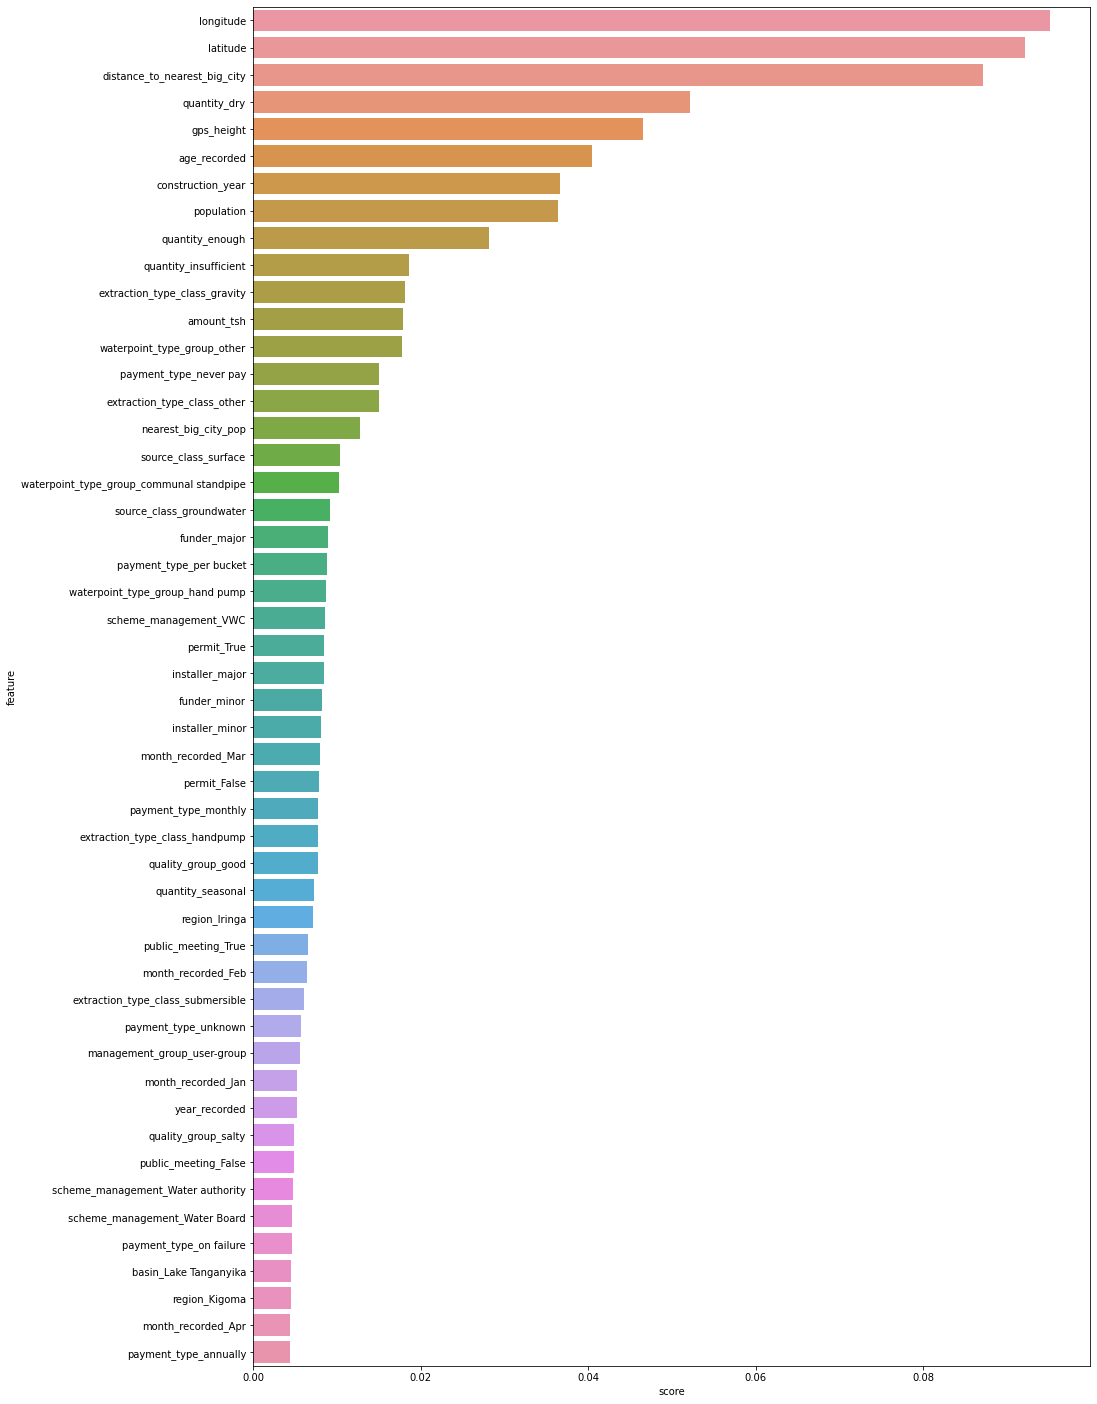

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 25))
ax = sns.barplot(x='score', y='feature', data=feature_importance[:50]);

### Fitting models on the more specific features

### RandomizedSearchCV

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create the random grid
random_grid = [{'rf__n_estimators': n_estimators,
                'rf__max_features': max_features,
                'rf__max_depth': max_depth,
                'rf__min_samples_split': min_samples_split,
                'rf__min_samples_leaf': min_samples_leaf,
                'rf__bootstrap': bootstrap}]

In [ ]:
pipe_sm = imbPipeline(steps=[('preprocessor', preprocessor),
                             ('sampling', SMOTE(random_state=2021)),
                             ('rf', RandomForestClassifier(random_state=2021))])

randsearch_rf_sm = RandomizedSearchCV(estimator=pipeline,
                                    param_distributions=random_grid,
                                    n_iter=50,
                                    scoring='accuracy',
                                    cv=3,
                                    verbose=2)

randsearch_rf_sm.fit(X_tt_sub, y_tt)

In [ ]:
from sklearn.metrics import recall_score

In [ ]:
def classification_report_with_wted_recall(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    return recall_score(y_true, y_pred, average='weighted')

wted_recall = make_scorer(classification_report_with_wted_recall)

In [ ]:
pipe_sm_model = pipe_sm.fit(X_tt_sub, y_tt)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
onehot_columns = pipe_sm_model.named_steps['preprocessor']\
                              .named_transformers_['cat']\
                              .named_steps['ohe']\
                              .get_feature_names(input_features=categorical_features)

# X_values = preprocessor.fit_transform(X_tt_sub)

# df_from_array_pipeline = pd.DataFrame(X_values, columns = numeric_features + list(onehot_columns))

feature_importance = pd.DataFrame({'feature': np.array(numeric_features + list(onehot_columns)),
                                   'score': pipe_sm_model.named_steps['rf'].feature_importances_})


In [ ]:
feature_importance

,feature,score
0,amount_tsh,0.019735
1,gps_height,0.046003
2,longitude,0.094555
3,latitude,0.092358
4,num_private,0.001609
...,...,...
123,month_recorded_Mar,0.007834
124,month_recorded_May,0.000408
125,month_recorded_Nov,0.001501
126,month_recorded_Oct,0.003113


In [ ]:
feature_importance.sort_values('score', ascending=False)[:50]

,feature,score
2,longitude,0.094555
3,latitude,0.092358
7,distance_to_nearest_big_city,0.087140
87,quantity_dry,0.055999
1,gps_height,0.046003
9,age_recorded,0.039081
6,construction_year,0.037727
5,population,0.036419
88,quantity_enough,0.027068
62,extraction_type_class_gravity,0.020992


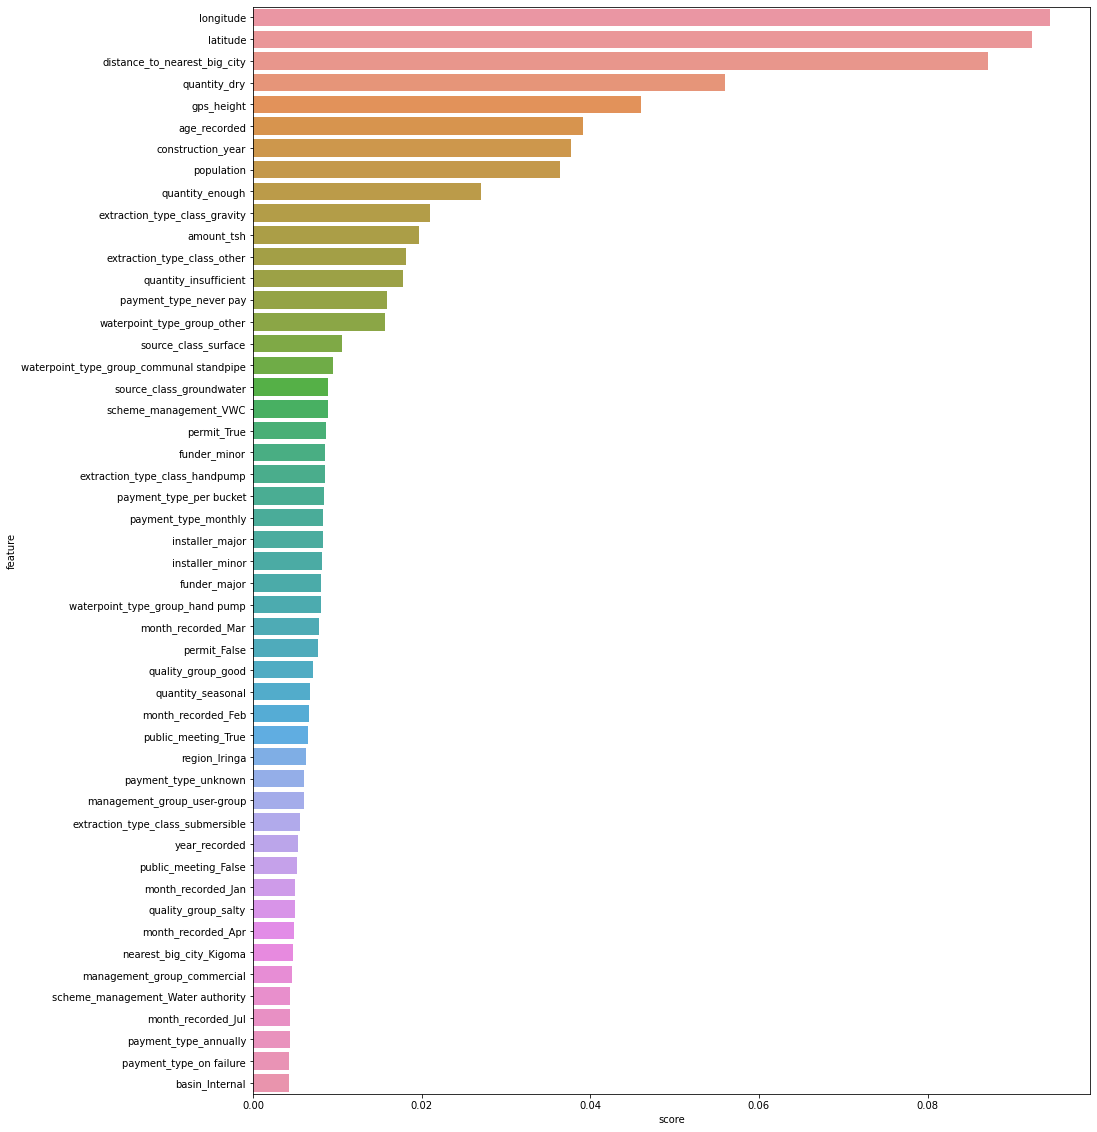

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,20))

ax = sns.barplot(y='feature', x='score', data=feature_importance.sort_values('score', ascending=False)[:50], orient='h')

In [ ]:
X_tt.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'coordinates',
       'nearest_big_city', 'distance_to_nearest_big_city', 'month_recorded',
       'year_recorded', 'age_recorded'],
      dtype='object')

In [ ]:
categorical_features_2 = ['funder', 'installer', 'basin', 'region', 'lga', 'ward', 'public_meeting', 'scheme_management',
                          'permit', 'extraction_type', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type',
                          'nearest_big_city', 'month_recorded']

In [ ]:
X_tt[categorical_features_2].head()

,funder,installer,basin,region,lga,ward,public_meeting,scheme_management,permit,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,nearest_big_city,month_recorded
53244,major,major,Pangani,Kilimanjaro,Moshi Rural,Old Moshi Magharibi,True,VWC,True,gravity,vwc,unknown,soft,enough,spring,communal standpipe,Moshi,Feb
1574,major,major,Internal,Shinyanga,Kishapu,Songwa,True,WUG,False,other,wug,unknown,salty,enough,shallow well,other,Shinyanga,Oct
7130,major,major,Internal,Singida,Singida Rural,Ughandi,True,VWC,NaN,mono,vwc,unknown,unknown,unknown,machine dbh,communal standpipe,Shinyanga,Mar
37177,major,major,Lake Rukwa,Mbeya,Mbozi,Iyula,False,VWC,False,nira/tanira,vwc,pay when scheme fails,unknown,seasonal,shallow well,hand pump,Mbeya,Aug
47500,major,minor,Wami / Ruvu,Morogoro,Mvomero,Hembeti,True,VWC,True,gravity,vwc,pay monthly,soft,enough,river,communal standpipe,Morogoro,Feb


In [ ]:
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features),
                                               ('cat', categorical_transformer, categorical_features_2)],
                                 remainder='drop')

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rf', RandomForestClassifier(random_state=2021))])

scores_rf2 = cross_val_score(pipeline, X_tt, y_tt, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.80      0.85      0.82      3548
functional needs repair       0.46      0.31      0.37       440
         non functional       0.79      0.76      0.77      2491

               accuracy                           0.78      6479
              macro avg       0.68      0.64      0.66      6479
           weighted avg       0.77      0.78      0.77      6479

                         precision    recall  f1-score   support

             functional       0.80      0.85      0.82      3548
functional needs repair       0.48      0.30      0.37       440
         non functional       0.80      0.77      0.78      2491

               accuracy                           0.78      6479
              macro avg       0.69      0.64      0.66      6479
           weighted avg       0.77      0.78      0.78      6479

                         precision    recall  f1-score   support

             funct

#### with SMOTE

In [ ]:
pipe_sm = imbPipeline(steps=[('preprocessor', preprocessor),
                             ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                             ('rf', RandomForestClassifier(random_state=2021))])

scores_rf_sm = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.83      0.81      3548
functional needs repair       0.39      0.40      0.39       440
         non functional       0.79      0.75      0.77      2491

               accuracy                           0.77      6479
              macro avg       0.66      0.66      0.66      6479
           weighted avg       0.77      0.77      0.77      6479



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.83      0.81      3548
functional needs repair       0.37      0.37      0.37       440
         non functional       0.80      0.75      0.77      2491

               accuracy                           0.77      6479
              macro avg       0.66      0.65      0.65      6479
           weighted avg       0.77      0.77      0.77      6479



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.85      0.82      3548
functional needs repair       0.41      0.41      0.41       440
         non functional       0.81      0.75      0.78      2490

               accuracy                           0.78      6478
              macro avg       0.68      0.67      0.67      6478
           weighted avg       0.78      0.78      0.78      6478



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.84      0.82      3548
functional needs repair       0.37      0.39      0.38       440
         non functional       0.81      0.76      0.78      2490

               accuracy                           0.78      6478
              macro avg       0.66      0.66      0.66      6478
           weighted avg       0.78      0.78      0.78      6478



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.84      0.82      3547
functional needs repair       0.40      0.39      0.39       440
         non functional       0.81      0.76      0.78      2491

               accuracy                           0.78      6478
              macro avg       0.67      0.66      0.67      6478
           weighted avg       0.78      0.78      0.78      6478



In [ ]:
scores_rf_sm.mean()

0.7736790212242456

### Investigate Feature Importances

In [ ]:
pipe_sm.fit(X_tt, y_tt)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                            

In [ ]:
pipe_sm.named_steps['rf'].feature_importances_

array([0.01919522, 0.09001027, 0.00197356, ..., 0.00147645, 0.00311729,
       0.00050364])

In [ ]:
ohe_cols = pipe_sm.named_steps['preprocessor']\
                  .named_transformers_['cat']\
                  .named_steps['ohe']\
                  .get_feature_names(input_features=categorical_features_2)
                
feature_importance = pd.DataFrame({'feature': np.array(numerical_features + list(ohe_cols)),
                                   'score': pipe_sm.named_steps['rf'].feature_importances_})
feature_importance

,feature,score
0,amount_tsh,0.019195
1,gps_height,0.090010
2,num_private,0.001974
3,construction_year,0.037001
4,year_recorded,0.005288
...,...,...
2271,month_recorded_Mar,0.008286
2272,month_recorded_May,0.000516
2273,month_recorded_Nov,0.001476
2274,month_recorded_Oct,0.003117


In [ ]:
feature_importance = feature_importance.sort_values(by='score', ascending=False)

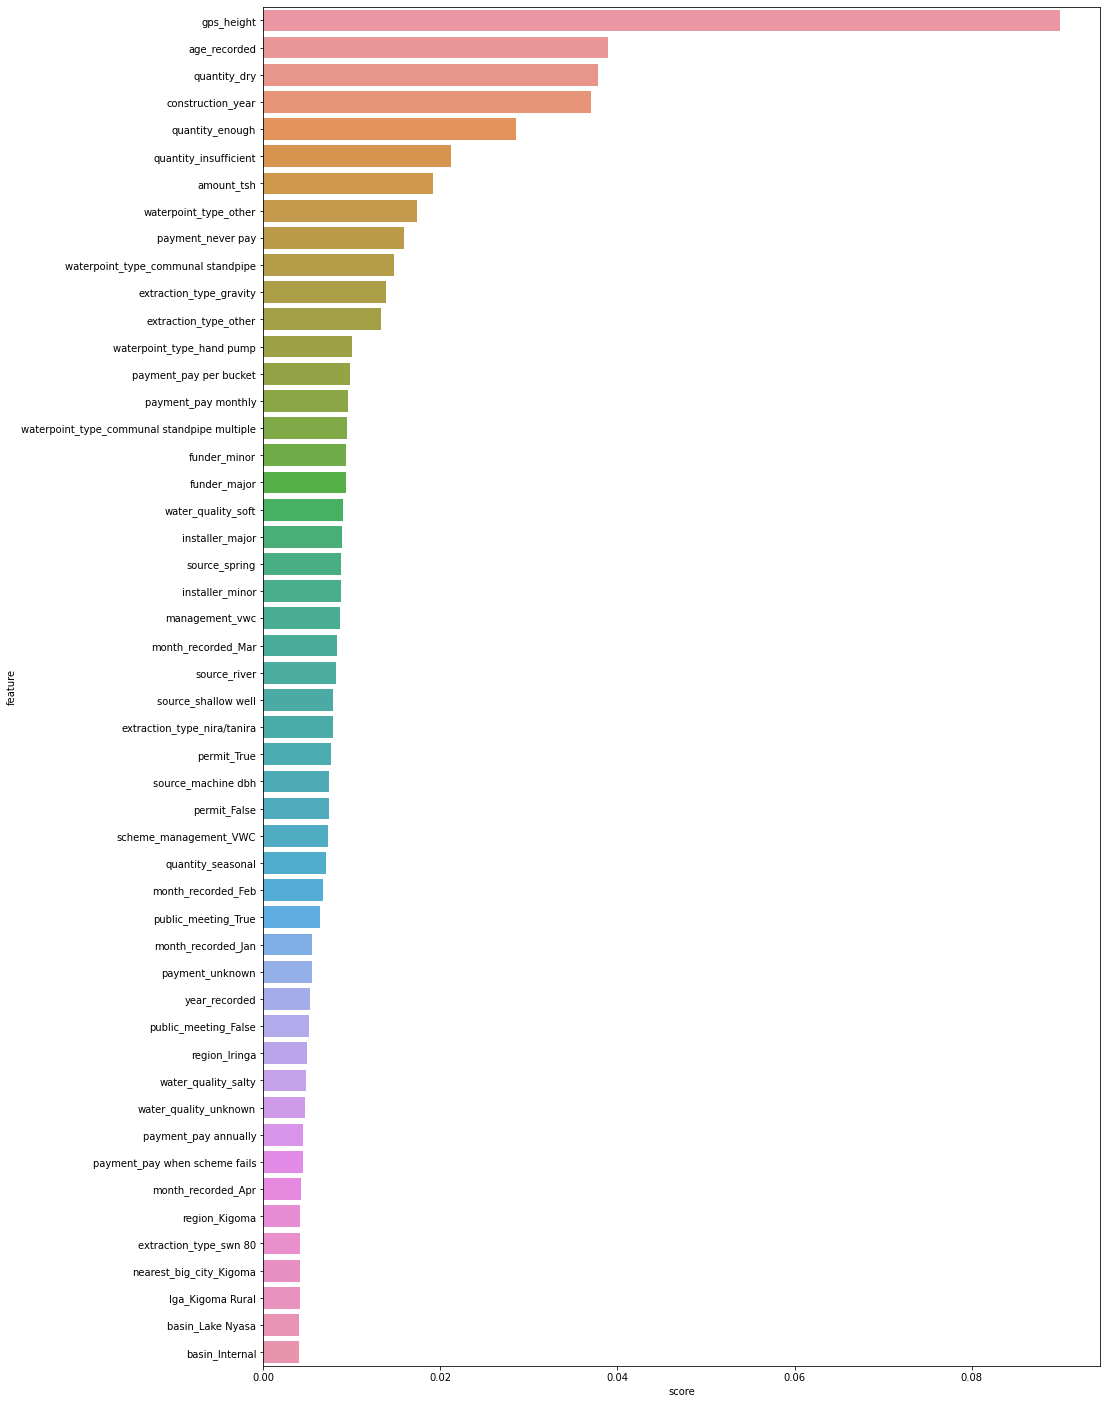

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 25))
ax = sns.barplot(x='score', y='feature', data=feature_importance[:50]);

In [ ]:
len(feature_importance)

2276

Using more specific features increases total number of features up to 2276 (compared to 128 features in the first model), while only improves average cross validation accuracy by roughly 1%. It's computationally more expensive, and a good portion of the 2276 models contribute very little to the target variable. Therefore, I'll proceed with the first set of selected features.

In [ ]:
top_50 = rf_sm1_fi[:50]

### Feature Selection

Based on the below `top_50` list, I think it's safe to remove `num_private` from the list of `numerical_features` to be included in my Random Forest model.

In [ ]:
top_50 = feature_importance[:50].copy()
top_50

,feature,score
8,longitude,0.095167
9,latitude,0.092112
10,distance_to_nearest_big_city,0.087182
88,quantity_dry,0.052112
1,gps_height,0.046560
5,age_recorded,0.040438
3,construction_year,0.036665
6,population,0.036367
89,quantity_enough,0.028151
90,quantity_insufficient,0.018672


In [ ]:
numerical_features.remove('num_private')

### GridSearchCV

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [75, 90, 105, 120],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500]
}

In [ ]:
grid = [{
    'randfor__n_estimators': [100, 300, 500],
    'randfor__criterion': ['gini', 'entropy'],
    'randfor__max_features': ['auto', 'sqrt', 'log2'],
    'randfor__max_depth' 
}]

In [ ]:
# min_samples_split = 10 --> NOPE
pipe_sm = imbPipeline(steps=[('preprocessor', preprocessor),
                             ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                             ('rf', RandomForestClassifier(random_state=2021, min_samples_split=10))])

scores_rf_sm1 = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy, cv=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.85      0.82      5913
functional needs repair       0.35      0.43      0.38       734
         non functional       0.84      0.73      0.78      4151

               accuracy                           0.77     10798
              macro avg       0.66      0.67      0.66     10798
           weighted avg       0.78      0.77      0.78     10798



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.85      0.82      5913
functional needs repair       0.36      0.43      0.39       733
         non functional       0.85      0.73      0.79      4151

               accuracy                           0.78     10797
              macro avg       0.67      0.67      0.67     10797
           weighted avg       0.79      0.78      0.78     10797



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.79      0.85      0.82      5913
functional needs repair       0.35      0.40      0.37       733
         non functional       0.84      0.73      0.78      4151

               accuracy                           0.78     10797
              macro avg       0.66      0.66      0.66     10797
           weighted avg       0.78      0.78      0.78     10797



In [ ]:
scores_rf_sm1.mean()

0.7758089165521289

In [ ]:
# n_estimators=300 --> NOPE
pipe_sm = imbPipeline(steps=[('preprocessor', preprocessor),
                             ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                             ('rf', RandomForestClassifier(random_state=2021, n_estimators=300))])

scores = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy, cv=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.84      0.82      5913
functional needs repair       0.39      0.41      0.40       734
         non functional       0.82      0.75      0.79      4151

               accuracy                           0.78     10798
              macro avg       0.67      0.67      0.67     10798
           weighted avg       0.78      0.78      0.78     10798



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.85      0.82      5913
functional needs repair       0.38      0.40      0.39       733
         non functional       0.83      0.76      0.79      4151

               accuracy                           0.78     10797
              macro avg       0.67      0.67      0.67     10797
           weighted avg       0.78      0.78      0.78     10797



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.83      0.82      5913
functional needs repair       0.36      0.37      0.37       733
         non functional       0.81      0.76      0.79      4151

               accuracy                           0.77     10797
              macro avg       0.66      0.66      0.66     10797
           weighted avg       0.78      0.77      0.78     10797



In [ ]:
scores.mean()

0.7786490372895468

### XGBoost

In [ ]:
numerical_features

['amount_tsh',
 'gps_height',
 'construction_year',
 'year_recorded',
 'age_recorded',
 'population',
 'nearest_big_city_pop',
 'longitude',
 'latitude',
 'distance_to_nearest_big_city']

In [ ]:
pipe_xgb = imbPipeline(steps=[('preprocessor', preprocessor),
                              ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                              ('xgb_clf', XGBClassifier())])

scores = cross_val_score(pipe_xgb, X_tt, y_tt, scoring=scr_accuracy, cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.73      0.84      0.78      3548
functional needs repair       0.23      0.41      0.30       440
         non functional       0.85      0.56      0.68      2491

               accuracy                           0.70      6479
              macro avg       0.61      0.60      0.59      6479
           weighted avg       0.75      0.70      0.71      6479



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.73      0.84      0.78      3548
functional needs repair       0.25      0.40      0.31       440
         non functional       0.84      0.56      0.67      2491

               accuracy                           0.71      6479
              macro avg       0.61      0.60      0.59      6479
           weighted avg       0.74      0.71      0.71      6479



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.73      0.81      0.77      3548
functional needs repair       0.22      0.43      0.29       440
         non functional       0.85      0.56      0.68      2490

               accuracy                           0.69      6478
              macro avg       0.60      0.60      0.58      6478
           weighted avg       0.74      0.69      0.70      6478



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.73      0.85      0.79      3548
functional needs repair       0.23      0.37      0.28       440
         non functional       0.86      0.58      0.69      2490

               accuracy                           0.71      6478
              macro avg       0.61      0.60      0.59      6478
           weighted avg       0.75      0.71      0.72      6478



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.72      0.84      0.78      3547
functional needs repair       0.21      0.35      0.26       440
         non functional       0.84      0.56      0.67      2491

               accuracy                           0.70      6478
              macro avg       0.59      0.58      0.57      6478
           weighted avg       0.73      0.70      0.70      6478



In [ ]:
pipe_xgb = imbPipeline(steps=[('preprocessor', preprocessor),
                              ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                              ('xgb_clf', XGBClassifier(verbosity=2, subsample=0.8,
                                                        seed=2021))])

In [ ]:
parameters = {'xgb_clf__booster': ['dart', 'gblinear'],
              'xgb_clf__objective':['multi:softprob'],
              'xgb_clf__learning_rate': [0.02,0.04], 
              'xgb_clf__max_depth': [6,8]}

In [ ]:
gridsearch_xgb = GridSearchCV(estimator=pipe_xgb,
                              param_grid=parameters,
                              scoring='accuracy',
                              cv=3,
                              verbose=2,
                              return_train_score=True)

gridsearch_xgb.fit(X_tt, y_tt)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] xgb_clf__booster=dart, xgb_clf__learning_rate=0.02, xgb_clf__max_depth=6, xgb_clf__objective=multi:softprob 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[01:32:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[01:32:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[01:32:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[01:32:35] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:32:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[01:32:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[01:32:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[01:32:35] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:32:35] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning en

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[01:33:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[01:33:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[01:33:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[01:33:39] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:33:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[01:33:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[01:33:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[01:33:40] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:33:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[01:34:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[01:34:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[01:34:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[01:34:44] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:34:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[01:34:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[01:34:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[01:34:44] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:34:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[01:35:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[01:35:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[01:35:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[01:35:49] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:35:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[01:35:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[01:35:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[01:35:50] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:35:50] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[01:37:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[01:37:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[01:37:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[01:37:18] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:37:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[01:37:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[01:37:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[01:37:18] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:37:18] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[01:38:46] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[01:38:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[01:38:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=8
[01:38:47] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:38:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[01:38:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[01:38:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[01:38:47] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:38:47] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[01:40:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[01:40:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[01:40:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[01:40:14] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:40:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[01:40:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[01:40:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[01:40:15] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:40:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning en

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[01:41:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[01:41:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[01:41:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[01:41:22] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:41:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[01:41:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[01:41:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[01:41:22] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:41:22] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[01:42:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[01:42:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[01:42:29] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[01:42:29] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:42:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[01:42:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[01:42:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[01:42:30] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:42:30] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[01:43:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[01:43:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[01:43:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[01:43:37] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:43:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[01:43:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[01:43:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[01:43:38] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:43:38] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[01:45:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[01:45:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[01:45:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[01:45:08] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:45:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=8
[01:45:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[01:45:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[01:45:09] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:45:09] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[01:46:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[01:46:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[01:46:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=8
[01:46:39] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:46:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[01:46:39] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[01:46:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[01:46:40] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:46:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.02, xgb_clf__max_depth=6, xgb_clf__objective=multi:softprob, total=  10.5s
[CV] xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.02, xgb_clf__max_depth=6, xgb_clf__objective=multi:softprob 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.02, xgb_clf__max_depth=6, xgb_clf__objective=multi:softprob, total=  10.8s
[CV] xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.02, xgb_clf__max_depth=6, xgb_clf__objective=multi:softprob 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.02, xgb_clf__max_depth=6, xgb_clf__objective=multi:softprob, total=  10.5s
[CV] xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.02, xgb_clf__max_depth=8, xgb_clf__objective=multi:softprob 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.02, xgb_clf__max_depth=8, xgb_clf__objective=multi:softprob, total=  10.5s
[CV] xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.02, xgb_clf__max_depth=8, xgb_clf__objective=multi:softprob 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.02, xgb_clf__max_depth=8, xgb_clf__objective=multi:softprob, total=  10.6s
[CV] xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.02, xgb_clf__max_depth=8, xgb_clf__objective=multi:softprob 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.02, xgb_clf__max_depth=8, xgb_clf__objective=multi:softprob, total=  10.5s
[CV] xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.04, xgb_clf__max_depth=6, xgb_clf__objective=multi:softprob 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.04, xgb_clf__max_depth=6, xgb_clf__objective=multi:softprob, total=  10.5s
[CV] xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.04, xgb_clf__max_depth=6, xgb_clf__objective=multi:softprob 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.04, xgb_clf__max_depth=6, xgb_clf__objective=multi:softprob, total=  10.6s
[CV] xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.04, xgb_clf__max_depth=6, xgb_clf__objective=multi:softprob 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.04, xgb_clf__max_depth=6, xgb_clf__objective=multi:softprob, total=  10.5s
[CV] xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.04, xgb_clf__max_depth=8, xgb_clf__objective=multi:softprob 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.04, xgb_clf__max_depth=8, xgb_clf__objective=multi:softprob, total=  10.5s
[CV] xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.04, xgb_clf__max_depth=8, xgb_clf__objective=multi:softprob 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.04, xgb_clf__max_depth=8, xgb_clf__objective=multi:softprob, total=  10.5s
[CV] xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.04, xgb_clf__max_depth=8, xgb_clf__objective=multi:softprob 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[CV]  xgb_clf__booster=gblinear, xgb_clf__learning_rate=0.04, xgb_clf__max_depth=8, xgb_clf__objective=multi:softprob, total=  10.2s


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 17.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[01:50:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=8
[01:50:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[01:50:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=8
[01:50:23] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:50:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=8
[01:50:23] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=8
[01:50:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[01:50:24] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[01:50:24] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          MinMaxScaler(copy=True,
                                                                                                       feature_range=(0,
                                          

In [ ]:
gridsearch_xgb.best_params_

{'xgb_clf__booster': 'dart',
 'xgb_clf__learning_rate': 0.04,
 'xgb_clf__max_depth': 8,
 'xgb_clf__objective': 'multi:softprob'}

In [ ]:
gridsearch_xgb.best_score_

0.739812209251483

In [ ]:
gridsearch_xgb.cv_results_['mean_train_score']

array([0.71298464, 0.74536924, 0.73479561, 0.76909425, 0.4111509 ,
       0.4111509 , 0.41666154, 0.41666154])

In [ ]:
# learning_rate=0.05
pipe_xgb = imbPipeline(steps=[('preprocessor', preprocessor),
                              ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                              ('xgb_clf', XGBClassifier(verbosity=2, subsample=0.8, booster='dart', learning_rate=0.05,
                                                        seed=2021, max_depth=8, objective='multi:softprob'))])
scores = cross_val_score(pipe_xgb, X_tt, y_tt, scoring=scr_accuracy, cv=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[02:07:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[02:07:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[02:07:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[02:07:12] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:07:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[02:07:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[02:07:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[02:07:12] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:07:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[02:08:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[02:08:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[02:08:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[02:08:43] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:08:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[02:08:43] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[02:08:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[02:08:44] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:08:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[02:10:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[02:10:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[02:10:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=8
[02:10:13] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:10:13] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[02:10:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[02:10:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[02:10:14] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:10:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

In [ ]:
scores.mean()

0.7423745465071797

In [ ]:
# learning_rate=0.055, multi:softmax
pipe_xgb = imbPipeline(steps=[('preprocessor', preprocessor),
                              ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                              ('xgb_clf', XGBClassifier(verbosity=2, subsample=0.7, booster='dart', learning_rate=0.055,
                                                        seed=2021, max_depth=8, objective='multi:softmax'))])
scores = cross_val_score(pipe_xgb, X_tt, y_tt, scoring=scr_accuracy, cv=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[02:14:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=8
[02:14:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=8
[02:14:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[02:14:08] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:14:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[02:14:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[02:14:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[02:14:08] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:14:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[02:15:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[02:15:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=8
[02:15:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[02:15:40] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:15:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[02:15:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[02:15:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[02:15:40] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:15:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[02:17:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=8
[02:17:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=8
[02:17:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=8
[02:17:12] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:17:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=8
[02:17:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=8
[02:17:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=8
[02:17:12] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:17:12] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

In [ ]:
scores.mean()

0.747468325372315

In [ ]:
X_tt[numerical_features].describe()

,amount_tsh,gps_height,construction_year,year_recorded,age_recorded,population,nearest_big_city_pop,longitude,latitude,distance_to_nearest_big_city
count,32392.000000,32392.000000,32392.000000,32392.000000,32392.000000,32392.000000,3.239200e+04,32392.000000,32392.000000,32392.000000
mean,318.307946,686.913281,1333.171061,2011.914423,678.743363,185.064584,4.053527e+05,35.131636,-5.868016,106.173377
std,2567.592807,694.876381,940.712753,0.959763,940.343126,492.281837,6.502372e+05,2.611298,2.801531,86.945530
min,0.000000,-63.000000,0.000000,2002.000000,-5.000000,0.000000,1.073620e+05,29.610321,-11.586297,0.247254
25%,0.000000,0.000000,0.000000,2011.000000,8.000000,0.000000,1.264490e+05,33.251330,-8.613112,43.061426
50%,0.000000,416.000000,1988.000000,2012.000000,25.000000,32.000000,2.248760e+05,34.990960,-5.132981,83.837645
75%,25.000000,1330.000000,2004.000000,2013.000000,2011.000000,230.000000,3.411360e+05,37.210905,-3.371634,143.528505
max,200000.000000,2626.000000,2013.000000,2013.000000,2013.000000,30500.000000,2.698652e+06,40.345193,-0.998464,451.995355


In [ ]:
pop_test = RobustScaler().fit_transform(X_tt[['population']])

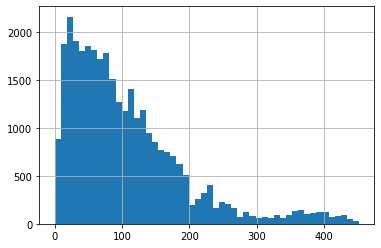

In [ ]:
X_tt_test.distance_to_nearest_big_city.hist(bins=50);

In [ ]:
from sklearn.preprocessing import PowerTransformer
ss = PowerTransformer(method='box-cox')

In [ ]:
X_tt_test['scaled_distance_to_city'] = ss.fit_transform (X_tt_test[['distance_to_nearest_big_city']])
# X_tt_test['scaled_distance_to_city'] = np.log(X_tt_test.distance_to_nearest_big_city)

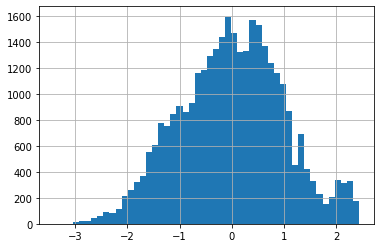

In [ ]:
X_tt_test['scaled_distance_to_city'].hist(bins=50);

In [ ]:
from sklearn.preprocessing import QuantileTransformer

In [ ]:
X_tt_test = X_tt.copy()

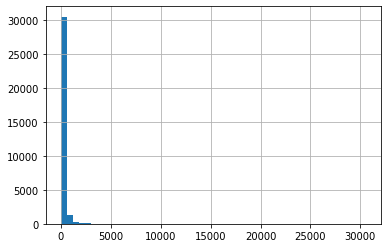

In [ ]:
X_tt_test['population'].hist(bins=50);

In [ ]:
X_tt_test['scaled_population'] = QuantileTransformer().fit_transform (X_tt_test[['population']])

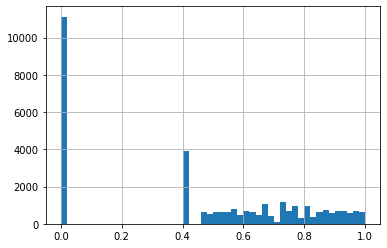

In [ ]:
X_tt_test.scaled_population.hist(bins=50);

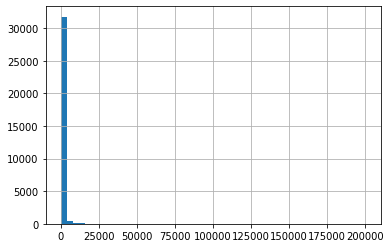

In [ ]:
X_tt_test.amount_tsh.hist(bins=50);

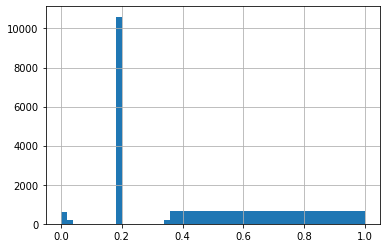

In [ ]:
X_tt_test['scaled_tsh'] = MinMaxScaler().fit_transform (X_tt_test[['amount_tsh']])
X_tt_test['scaled_gps'].hist(bins=50);

In [ ]:
np.array(numerical_features)

array(['amount_tsh', 'gps_height', 'construction_year', 'year_recorded',
       'age_recorded', 'population', 'nearest_big_city_pop', 'longitude',
       'latitude', 'distance_to_nearest_big_city'], dtype='<U28')

Create different transformers for different numerical features:
- poplation: QuantileTransformer()
- distance_to_nearest_big_city: PowerTransformer(method='box-cox')
- longitude, latitude, amount_tsh, gps_height: MinMaxScaler()

In [ ]:
to_quantile = ['population']
to_boxcox = ['distance_to_nearest_big_city']
to_minmax = ['amount_tsh', 'gps_height', 'construction_year', 'year_recorded', 'age_recorded',
             'longitude', 'latitude', 'distance_to_nearest_big_city']

In [ ]:
quantile_transformer = Pipeline(steps=[('quantile', QuantileTransformer())])

boxcox_transformer = Pipeline(steps=[('boxcox', PowerTransformer(method='box-cox'))])

minmax_transformer = Pipeline(steps=[('minmax', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_2 = ColumnTransformer(transformers=[('qut', quantile_transformer, to_quantile),
                                                 ('bcx', boxcox_transformer, to_boxcox),
                                                 ('mmx', minmax_transformer, to_minmax),
                                                 ('cat', categorical_transformer, categorical_features)],
                                   remainder='drop')

In [ ]:
pipe_xgb = imbPipeline(steps=[('preprocessor', preprocessor_2),
                              ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                              ('xgb_clf', XGBClassifier(verbosity=2, subsample=0.7, booster='dart', learning_rate=0.055,
                                                        seed=2021, max_depth=8, objective='multi:softmax'))])
scores = cross_val_score(pipe_xgb, X_tt, y_tt, scoring=scr_accuracy, cv=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[02:58:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[02:58:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[02:58:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[02:58:32] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:58:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[02:58:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[02:58:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[02:58:32] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[02:58:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[03:00:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=8
[03:00:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[03:00:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[03:00:08] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[03:00:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[03:00:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[03:00:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[03:00:08] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[03:00:08] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[03:01:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[03:01:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[03:01:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[03:01:41] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[03:01:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=8
[03:01:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[03:01:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[03:01:42] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[03:01:42] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

In [ ]:
scores.mean()

0.7457396387693391

In [ ]:
pipe_sm = imbPipeline(steps=[('preprocessor', preprocessor_2),
                             ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                             ('rf', RandomForestClassifier(random_state=2021))])

scores_rf = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy, cv=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.84      0.82      5913
functional needs repair       0.37      0.40      0.38       734
         non functional       0.82      0.75      0.78      4151

               accuracy                           0.78     10798
              macro avg       0.66      0.66      0.66     10798
           weighted avg       0.78      0.78      0.78     10798



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.85      0.82      5913
functional needs repair       0.38      0.40      0.39       733
         non functional       0.82      0.76      0.79      4151

               accuracy                           0.78     10797
              macro avg       0.67      0.67      0.67     10797
           weighted avg       0.78      0.78      0.78     10797



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.83      0.82      5913
functional needs repair       0.36      0.38      0.37       733
         non functional       0.81      0.76      0.78      4151

               accuracy                           0.77     10797
              macro avg       0.66      0.66      0.66     10797
           weighted avg       0.77      0.77      0.77     10797



In [ ]:
scores_rf.mean()

0.7766423870803156

In [ ]:
pipe_sm = imbPipeline(steps=[('preprocessor', preprocessor_2),
                             ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                             ('knn', KNeighborsClassifier())])

scores_knn = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy, cv=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.78      0.75      0.77      5913
functional needs repair       0.24      0.57      0.33       734
         non functional       0.80      0.64      0.71      4151

               accuracy                           0.70     10798
              macro avg       0.61      0.65      0.60     10798
           weighted avg       0.75      0.70      0.72     10798



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.78      0.76      0.77      5913
functional needs repair       0.23      0.58      0.33       733
         non functional       0.81      0.64      0.71      4151

               accuracy                           0.70     10797
              macro avg       0.61      0.66      0.60     10797
           weighted avg       0.76      0.70      0.72     10797



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.78      0.75      0.77      5913
functional needs repair       0.23      0.55      0.33       733
         non functional       0.80      0.65      0.71      4151

               accuracy                           0.70     10797
              macro avg       0.60      0.65      0.60     10797
           weighted avg       0.75      0.70      0.72     10797



In [ ]:
pipe_xgb = imbPipeline(steps=[('preprocessor', preprocessor_2),
                              ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                              ('xgb_clf', XGBClassifier(verbosity=2, subsample=0.7, booster='dart', learning_rate=0.06,
                                                        seed=2021, max_depth=8, objective='multi:softprob'))])
scores = cross_val_score(pipe_xgb, X_tt, y_tt, scoring=scr_accuracy, cv=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[03:10:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[03:10:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[03:10:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=8
[03:10:07] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[03:10:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[03:10:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[03:10:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=8
[03:10:07] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[03:10:07] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[03:11:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=8
[03:11:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[03:11:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=8
[03:11:41] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[03:11:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=8
[03:11:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=8
[03:11:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[03:11:41] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[03:11:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[03:13:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[03:13:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=8
[03:13:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=8
[03:13:14] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[03:13:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=8
[03:13:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=8
[03:13:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[03:13:15] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[03:13:15] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning

In [ ]:
scores.mean()

0.7481476464679645

In [ ]:
from sklearn.svm import LinearSVC # PROBABLY NOT

In [ ]:
pipe_svc = imbPipeline(steps=[('preprocessor', preprocessor_2),
                              ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                              ('svc_clf', LinearSVC(random_state=2021, multi_class='crammer_singer'))])
scores = cross_val_score(pipe_svc, X_tt, y_tt, scoring=scr_accuracy, cv=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                         precision    recall  f1-score   support

             functional       0.74      0.68      0.71      5913
functional needs repair       0.16      0.66      0.26       734
         non functional       0.86      0.49      0.63      4151

               accuracy                           0.61     10798
              macro avg       0.59      0.61      0.53     10798
           weighted avg       0.75      0.61      0.65     10798



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                         precision    recall  f1-score   support

             functional       0.74      0.67      0.71      5913
functional needs repair       0.17      0.68      0.27       733
         non functional       0.84      0.50      0.63      4151

               accuracy                           0.61     10797
              macro avg       0.58      0.62      0.53     10797
           weighted avg       0.74      0.61      0.65     10797



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


                         precision    recall  f1-score   support

             functional       0.74      0.68      0.71      5913
functional needs repair       0.16      0.68      0.26       733
         non functional       0.85      0.48      0.61      4151

               accuracy                           0.60     10797
              macro avg       0.59      0.61      0.53     10797
           weighted avg       0.74      0.60      0.64     10797



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
pipe_xt = imbPipeline(steps=[('preprocessor', preprocessor_2),
                              ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                              ('svc_xt', ExtraTreesClassifier(random_state=2021))])
scores = cross_val_score(pipe_xt, X_tt, y_tt, scoring=scr_accuracy, cv=3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.82      0.81      5913
functional needs repair       0.37      0.40      0.38       734
         non functional       0.79      0.75      0.77      4151

               accuracy                           0.77     10798
              macro avg       0.65      0.66      0.66     10798
           weighted avg       0.77      0.77      0.77     10798



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.81      0.83      0.82      5913
functional needs repair       0.37      0.40      0.38       733
         non functional       0.80      0.76      0.78      4151

               accuracy                           0.77     10797
              macro avg       0.66      0.66      0.66     10797
           weighted avg       0.78      0.77      0.77     10797



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


                         precision    recall  f1-score   support

             functional       0.80      0.82      0.81      5913
functional needs repair       0.34      0.35      0.35       733
         non functional       0.79      0.76      0.78      4151

               accuracy                           0.76     10797
              macro avg       0.64      0.64      0.64     10797
           weighted avg       0.77      0.76      0.77     10797



In [ ]:
scores.mean()

0.7676896287764302

In [ ]:
grid = [{
    'rf__n_estimators': [100, 300, 500],
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__max_depth': [75, 90, 105, 120]
}]

In [ ]:
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [75, 90, 105, 120],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 300, 500]
# }

In [ ]:
awoughwpipe_rf = imbPipeline(steps=[('preprocessor', preprocessor_2),
                             ('sampling', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                             ('rf', RandomForestClassifier(random_state=2021))])

gridsearch_rf = GridSearchCV(estimator=pipe_rf,
                              param_grid=grid,
                              scoring='accuracy',
                              cv=3,
                              verbose=1,
                              return_train_score=True)

gridsearch_rf.fit(X_tt, y_tt)